# Input Files for the Model
The notebook contains the code for generating input files for the running the idealized channel model. This notebook is specifically for generating input files for higher-resolution run that is continued using a lower resolution run. Restart file generated from the lower resolution run is used for creating initial fields T, S, u, v. The input files include analytical profiles of forcings, restoration and sponge. A generic topography is also generated. To ensure that high resolution runs fine, we restrict the lats and lons at grid ppoints to have values within the range presbribed in the lower resolution run. This is because MOM6 will not extrapolate data in the initialization step.  


Attributes, units etc. in nc files should be kept the same as shown in this notebook, otherwise MOM6 may return errors or unexpected results.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from xgcm import Grid
import xesmf as xe
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import glob, os

import initialization_functions as infs

$\large \text{Generate Mercator Grid}$

In isotropic mercator grid, all cell boxes are squares to reduce grid distortion. Here, the meridional grid spacing ($\Delta \phi$) decreases towards the poles as
$$\Delta \phi = \Delta \lambda \cos(\phi)$$
where $\Delta \lambda$ and $\phi$ are the zonal grid spacing (in degrees) and latitude, respectively.The resulting latitude traced points are given as (assuming j = 0 for equator),

$$\phi (j) = \frac{\pi}{180} \arcsin \left[\tanh(j\pi/180)\right]$$

Either use this code or read grid info from a file as in the code below

In [4]:
# Determine lat-lon tracer points (range is smaller than low res runs)
R_E = 6.378e6

lats, latn = (-69.8, -30.2)
lonw, lone = (0.25, 79.75)

res = 0.25 / 3.  # Grid resolution
lon = np.arange(lonw + res/2., lone, res)

ind = np.arange(-1186, -381); # indices for 1/12th deg resolution, adjust ind based on resolution

lat = (180/np.pi)*np.arcsin(np.tanh(res*np.pi*ind/180)) 

dlat = res * np.cos(lat * np.pi/180)
dlon = np.ones(len(lon)) * res

# Compute grid spacing in m
Long, Lati = np.meshgrid(lon, lat)
dx, dy = np.meshgrid(dlon, dlat)

dx = dx * np.cos(Lati * np.pi/180.) * (2*np.pi*R_E/360.)
dy = dy * (2*np.pi*R_E/360.)

In [5]:
print("Lat:", lat)
print("Lon:", lon)

Lat: [-69.79424813 -69.76544578 -69.73660409 -69.70772303 -69.67880254
 -69.64984258 -69.6208431  -69.59180405 -69.5627254  -69.53360708
 -69.50444906 -69.47525129 -69.44601372 -69.41673631 -69.38741901
 -69.35806177 -69.32866454 -69.29922728 -69.26974995 -69.24023249
 -69.21067486 -69.18107701 -69.15143889 -69.12176047 -69.09204168
 -69.06228249 -69.03248285 -69.00264271 -68.97276202 -68.94284074
 -68.91287882 -68.88287621 -68.85283286 -68.82274874 -68.79262379
 -68.76245796 -68.73225121 -68.70200349 -68.67171475 -68.64138495
 -68.61101404 -68.58060197 -68.55014869 -68.51965416 -68.48911833
 -68.45854116 -68.42792259 -68.39726258 -68.36656108 -68.33581804
 -68.30503342 -68.27420717 -68.24333924 -68.21242959 -68.18147816
 -68.15048491 -68.11944979 -68.08837276 -68.05725377 -68.02609276
 -67.9948897  -67.96364453 -67.93235721 -67.90102769 -67.86965592
 -67.83824186 -67.80678545 -67.77528665 -67.74374541 -67.71216169
 -67.68053544 -67.6488666  -67.61715514 -67.585401   -67.55360413
 -67.

In [8]:
DX = xr.DataArray(dx,coords=[("yh",lat), ("xh",lon)])
DY = xr.DataArray(dy,coords=[("yh",lat), ("xh",lon)])

X,Y = infs.calc_XYmeters_gen(DX.yh, DX.xh, DX, DY, 'yh', 'xh',center_x = True)

X.lonh.attrs['units'] = "degrees_east"
X.lonh.attrs['standard_name'] = "Longitude"
X.lonh.attrs['cartesian_axis'] = "X"
X.lonh.encoding['_FillValue'] = False

X.lath.attrs['units'] = "degrees_north"
X.lath.attrs['standard_name'] = "Latitude"
X.lath.attrs['cartesian_axis'] = "Y"
X.lath.encoding['_FillValue'] = False

Y.lonh.attrs['units'] = "degrees_east"
Y.lonh.attrs['standard_name'] = "Longitude"
Y.lonh.attrs['cartesian_axis'] = "X"
Y.lonh.encoding['_FillValue'] = False

Y.lath.attrs['units'] = "degrees_north"
Y.lath.attrs['standard_name'] = "Latitude"
Y.lath.attrs['cartesian_axis'] = "Y"
Y.lath.encoding['_FillValue'] = False

Text(0.5, 1.0, 'dy')

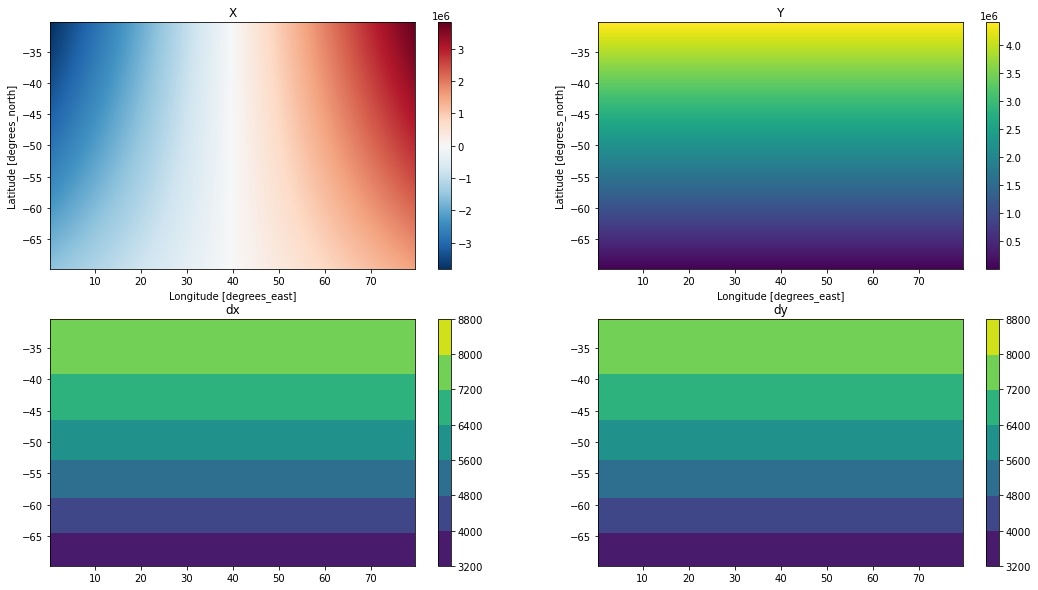

In [9]:
fig = plt.figure(figsize=[18,10])

plt.subplot(2,2,1)
X.plot()
plt.title('X')

plt.subplot(2,2,2)
Y.plot()
plt.title('Y')

plt.subplot(2,2,3)
plt.contourf(lon, lat, dx)
plt.colorbar()
plt.title('dx')

plt.subplot(2,2,4)
plt.contourf(lon, lat, dy)
plt.colorbar()
plt.title('dy')

$\large \text{Mosaic Grid}$

If mosaic grid option is chosen in MOM6, then grid coordinates (x ,y in deg.), grid spacings (dx, dy in meters) and cell areas (in m^2) need to be provided. These arrays contain both cell center and corner points; therefore, array sizes are (2 * Ny + 1, 2 * Nx + 1). The function below generates required arrays. 

Note - In isotropic mercator grid, zonal and meridional extent are not independent of number of grid points. The model may return error, if the the numbers are not consistet. In that case, supplying grid info may be an easier option.  

In [10]:
def grid_mosaic(lat, lon, dlat, dlon, R_E):
        
    Ny = lat.shape[0]
    Nx = lon.shape[0]
    
    # Number of points for arrays in the grid file
    nyp = 2*Ny + 1; nxp = 2*Nx + 1
    ny = 2*Ny; nx = 2*Nx
    
    # define arrays
    x1 = np.zeros([nyp, nxp])
    y1 = np.zeros([nyp, nxp])
    area1 = np.zeros([ny, nx])
    
    for i in range(0,nyp):
        x1[i,0:nxp-1:2] = lon - dlon/2.
        x1[i:,1::2] = lon
        x1[i,nxp-1] = lon[Nx-1] + dlon[Nx-1]/2.
    
    for i in range(0,nxp):
        y1[0:nyp-1:2,i] = lat - dlat/2.
        y1[1::2, i] = lat
        y1[nyp-1,i] = lat[Ny-1] + dlat[Ny-1]/2.
    
    dx1 = np.diff(x1,axis=1)
    dy1 = np.diff(y1,axis=0)
    
    dx1 = dx1 * np.cos(y1[:,0:nx] * np.pi/180.) * (2*np.pi*R_E/360.)
    dy1 = dy1 * (2*np.pi*R_E/360.)
    
    for j in range(0, ny):
        for i in range(0, nx):
            
            area1[j,i] = dx1[j,i] * dy1[j,i]
    
    grid = xr.Dataset()
    
    grid['x'] = xr.DataArray(x1,dims=['nyp','nxp'])
    grid['y'] = xr.DataArray(y1,dims=['nyp','nxp'])
    grid['dx'] = xr.DataArray(dx1,dims=['nyp','nx'])
    grid['dy'] = xr.DataArray(dy1,dims=['ny','nxp'])
    grid['area'] = xr.DataArray(area1,dims=['ny','nx'])
    
    return grid

In [11]:
grid = grid_mosaic(lat, lon, dlat, dlon, R_E)
print(grid)

<xarray.Dataset>
Dimensions:  (nx: 1908, nxp: 1909, ny: 1610, nyp: 1611)
Dimensions without coordinates: nx, nxp, ny, nyp
Data variables:
    x        (nyp, nxp) float64 0.25 0.2917 0.3333 0.375 ... 79.67 79.71 79.75
    y        (nyp, nxp) float64 -69.81 -69.81 -69.81 ... -30.28 -30.28 -30.28
    dx       (nyp, nx) float64 1.601e+03 1.601e+03 ... 4.006e+03 4.006e+03
    dy       (ny, nxp) float64 1.602e+03 1.602e+03 ... 4.004e+03 4.004e+03
    area     (ny, nx) float64 2.565e+06 2.565e+06 ... 1.603e+07 1.603e+07


In [12]:
grid = grid_mosaic(lat, lon, dlat, dlon, R_E)

grid.x.attrs['units'] = "degrees_east"
grid.x.attrs['standard_name'] = "geographic_longitude"
grid.x.encoding['_FillValue'] = False

grid.y.attrs['units'] = "degrees_north"
grid.y.attrs['standard_name'] = "geographic_latitude"
grid.y.encoding['_FillValue'] = False

grid.dx.attrs['units'] = "meters"
grid.dx.attrs['standard_name'] = "grid_edge_x_distance"
grid.dx.encoding['_FillValue'] = False

grid.dy.attrs['units'] = "meters"
grid.dy.attrs['standard_name'] = "grid_edge_y_distance"
grid.dy.encoding['_FillValue'] = False

grid.area.attrs['units'] = "m2"
grid.area.attrs['standard_name'] = "grid_cell_area"
grid.area.encoding['_FillValue'] = False

grid.to_netcdf('/work/Hemant.Khatri/MOM6_idealised/PEM_ACC/N_75/MOM6_Channel_Input/Res_008_new/hgrid'+'.nc')

$\large \text{Vertical grid and layer densities} $

In [13]:
# Vertical grid
nk = 75
max_depth = 4000.
min_depth = 0.
thkcello_topcell = 1.
method = 'powerlaw'

vgrid = infs.calc_vgrid(nk=nk,max_depth=max_depth,min_depth=min_depth,
                        thkcello_topcell=thkcello_topcell,method=method)

Rs, Rn = (1023.5, 1028.5)  
density = infs.calc_distribution(coordinate = vgrid['zw'], function='linear', val_at_maxcoord = Rn, val_at_mincoord = Rs)
sigma2 = xr.DataArray(density.values,coords=[vgrid['NKp1']],dims=['NKp1'])

vgrid = xr.merge([vgrid, sigma2.rename("sigma2")])

d = xr.DataArray((vgrid['sigma2'].values[1:] + vgrid['sigma2'].values[:-1]) / 2.,coords=[vgrid['NK']],dims=['NK'])
vgrid = xr.merge([vgrid, d.rename("Layer")])

vgrid.NK.encoding['_FillValue'] = False
vgrid.NKp1.encoding['_FillValue'] = False

vgrid.dz.attrs['units'] = "m"
vgrid.dz.attrs['standard_name'] = "z coordinate level thickness"
vgrid.dz.encoding['_FillValue'] = False

vgrid.zw.attrs['units'] = "m"
vgrid.zw.attrs['standard_name'] = "Diagnostic z coordinate interface position"
vgrid.zw.encoding['_FillValue'] = False

vgrid.zt.attrs['units'] = "m"
vgrid.zt.attrs['standard_name'] = "Diagnostic z coordinate level position"
vgrid.zt.encoding['_FillValue'] = False

vgrid.sigma2.attrs['units'] = "kg/m3"
vgrid.sigma2.attrs['standard_name'] = "Interface target potential density"
vgrid.sigma2.encoding['_FillValue'] = False

vgrid.Layer.attrs['units'] = "kg/m3"
vgrid.Layer.attrs['standard_name'] = "Layer target potential density"
vgrid.Layer.encoding['_FillValue'] = False

print(vgrid)

<xarray.Dataset>
Dimensions:  (NK: 75, NKp1: 76)
Coordinates:
  * NKp1     (NKp1) float64 0.0 1.0 3.787 8.252 ... 3.798e+03 3.898e+03 4e+03
  * NK       (NK) float64 0.5 2.393 6.02 11.3 ... 3.748e+03 3.848e+03 3.949e+03
Data variables:
    zw       (NKp1) float64 0.0 1.0 3.787 8.252 ... 3.798e+03 3.898e+03 4e+03
    zt       (NK) float64 0.5 2.393 6.02 11.3 ... 3.748e+03 3.848e+03 3.949e+03
    dz       (NK) float64 1.0 2.787 4.465 6.089 ... 98.04 99.31 100.6 101.8
    sigma2   (NKp1) float64 1.024e+03 1.024e+03 ... 1.028e+03 1.028e+03
    Layer    (NK) float64 1.024e+03 1.024e+03 1.024e+03 ... 1.028e+03 1.028e+03


In [14]:
vgrid.to_netcdf('/work/Hemant.Khatri/MOM6_idealised/PEM_ACC/N_75/MOM6_Channel_Input/Res_008_new/vgrid'+'.nc')

In [15]:
# vertical grid for saving data on ocean_model_z
nk = 35
max_depth = 4000.
min_depth = 0.
thkcello_topcell = 1.
method = 'powerlaw'

save_vgrid = infs.calc_vgrid(nk=nk,max_depth=max_depth,min_depth=min_depth,
                        thkcello_topcell=thkcello_topcell,method=method)

save_vgrid.NK.encoding['_FillValue'] = False
save_vgrid.NKp1.encoding['_FillValue'] = False

save_vgrid.dz.attrs['units'] = "m"
save_vgrid.dz.attrs['standard_name'] = "z coordinate level thickness"
save_vgrid.dz.encoding['_FillValue'] = False

save_vgrid.to_netcdf('/work/Hemant.Khatri/MOM6_idealised/PEM_ACC/N_75/MOM6_Channel_Input/Res_008_new/save_dz'+'.nc')

print(save_vgrid)

<xarray.Dataset>
Dimensions:  (NK: 35, NKp1: 36)
Coordinates:
  * NKp1     (NKp1) float64 0.0 1.0 5.038 12.97 ... 3.487e+03 3.738e+03 4e+03
  * NK       (NK) float64 0.5 3.019 9.006 ... 3.366e+03 3.613e+03 3.869e+03
Data variables:
    zw       (NKp1) float64 0.0 1.0 5.038 12.97 ... 3.487e+03 3.738e+03 4e+03
    zt       (NK) float64 0.5 3.019 9.006 ... 3.366e+03 3.613e+03 3.869e+03
    dz       (NK) float64 1.0 4.038 7.935 12.41 ... 231.7 241.5 251.5 261.5


$\large \text{Surface Forcing Files}$ 

Zonally uniform forcing profiles are created for wind stress and surface fluxes. These profiles inspired from SOSE and OM4 dataset (see SOSE_Forcing notebook and MOM6_example_forcing). The general form of the function is
$$f(y) = \sin\left(y + \frac{b}{2}\sin(a\cdot y)\right)^c$$
a, b, c coefficients control the shape and skewness of the profile. Recommended values are a = 1 or 2; b = [-2, 2] and c = 1 or 2.

In [16]:
# Wind Forcing

sponge_width = 2. # In degrees

taux_east = 0.15
taux_west = 0.05
Y0 = Y.isel(lonh =0, lath = np.abs(Y.lath.values + 63.0).argmin()).values # Boundary between ACC/ASF
Lc = Y.isel(lonh =0, lath = np.abs(Y.lath.values + 69.0).argmin()).values # South Zero
sp_wid = (np.max(Y.isel(lonh=0).values) - 
          Y.isel(lonh =0, lath = np.abs(Y.lath.values - np.max(Y.lath.values) + sponge_width).argmin()).values)

wind = xr.Dataset()
wind['taux'] = infs.calc_forcing_zonaluniform(Y,function='doublesinusoid_gen',
                                 sponge_width_max = sp_wid,
                                 northsouth_boundary = Y0,
                                 south_zeroregion = Lc, 
                                 max_north = taux_east, 
                                 max_south = taux_west, a=1., b=0.9, c=1., d=1., e=0, f=2.)

wind['tauy'] = infs.calc_forcing_zonaluniform(Y,function='doublesinusoid_gen',
                                 sponge_width_max = sp_wid,
                                 northsouth_boundary = Y0,
                                 south_zeroregion = Lc, 
                                 max_north = 0., 
                                 max_south = 0., a=1., b=0.9, c=1., d=1., e=0, f=2.)

wind = wind.expand_dims({"Time":np.array([0.])})

wind.Time.attrs['units'] = "days since 0001-01-01 00:00:00"
wind.Time.attrs['calendar'] = "noleap"
wind.Time.encoding['_FillValue'] = False

wind.taux.attrs['units'] = "N/m2"
wind.taux.attrs['standard_name'] = "Zonal wind stress"
wind.taux.attrs['_FillValue'] = -1.e34
wind.taux.attrs['missing_value'] = -1.e34

wind.tauy.attrs['units'] = "N/m2"
wind.tauy.attrs['standard_name'] = "Meridional wind stress"
wind.tauy.attrs['_FillValue'] = -1.e34
wind.tauy.attrs['missing_value'] = -1.e34

# Save
wind = wind.transpose('Time','lath','lonh')
wind.to_netcdf('/work/Hemant.Khatri/MOM6_idealised/PEM_ACC/N_75/MOM6_Channel_Input/Res_008_new/wind'+'.nc')

In [17]:
# Surface Fluxes of heat

buoyancy = xr.Dataset()
buoyancy['zero_forc'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['LW'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['SW'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
#buoyancy['latent'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['evap'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)


Buo_east = 20. # W/m^2
Buo_west = 10.
Y0 = Y.isel(lonh =0, lath = np.abs(Y.lath.values + 58.0).argmin()).values # Boundary between ACC/ASF
Lc = Y.isel(lonh =0, lath = np.abs(Y.lath.values + 69.0).argmin()).values # South Zero
sp_wid = np.max(Y.isel(lonh=0).values) - Y.isel(lonh =0, lath = np.abs(Y.lath.values - np.max(Y.lath.values) 
                                                                       + 2.).argmin()).values 

buoyancy['sensible'] = infs.calc_forcing_zonaluniform(Y,function='doublesinusoid_gen',
                                 sponge_width_max = sp_wid,
                                 northsouth_boundary = Y0,
                                 south_zeroregion = Lc, 
                                 max_north = Buo_east, 
                                 max_south = Buo_west, a=1., b=1.5, c=1., d=1., e=0., f=1.)

# Surface fresh water fluxes

Lat_fusion = 3.34e5 # J/kg

buoyancy['froz_runoff'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['liq_runoff'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)

Buo_east = -1.0e-5 # kg/m^2s
Buo_west = -1.8e-5
Y0 = Y.isel(lonh =0, lath = np.abs(Y.lath.values + 49.0).argmin()).values # Boundary between ACC/ASF
Lc = Y.isel(lonh =0, lath = np.abs(Y.lath.values + 69.0).argmin()).values # South Zero
sp_wid = np.max(Y.isel(lonh=0).values) - Y.isel(lonh =0, lath = np.abs(Y.lath.values - np.max(Y.lath.values) 
                                                                       + 2.).argmin()).values

# Liquid precipitation and evaporation
buoyancy['liq_precip'] = infs.calc_forcing_zonaluniform(Y,function='doublesinusoid_gen',
                                 sponge_width_max = sp_wid,
                                 northsouth_boundary = Y0,
                                 south_zeroregion = Lc, 
                                 max_north = Buo_east, 
                                 max_south = Buo_west, a=2., b=1.0, c=1., d=1., e=-1.5, f=1.)

# Flux due to freezing and sea-ice melt
Buo_east = 1.4e-5; Buo_west = 3.82e-5 # kg/m^2s 
Y0 = Y.isel(lonh =0, lath = np.abs(Y.lath.values + 65.0).argmin()).values # Boundary between ACC/ASF
Lc = Y.isel(lonh =0, lath = np.abs(Y.lath.values + 69.0).argmin()).values # South Zero
sp_wid = np.max(Y.isel(lonh=0).values) - Y.isel(lonh =0, lath = np.abs(Y.lath.values - np.max(Y.lath.values) + 27.).argmin()).values
buoyancy['froz_precip'] = infs.calc_forcing_zonaluniform(Y,function='doublesinusoid_gen',
                                 sponge_width_max = sp_wid,
                                 northsouth_boundary = Y0,
                                 south_zeroregion = Lc, 
                                 max_north = Buo_east, 
                                 max_south = Buo_west, a=2., b=1., c=1., d=2., e=1.0, f=2.)

In [18]:
A = np.zeros([Y.shape[0], Y.shape[1]])
dx = np.zeros([Y.shape[0], Y.shape[1]])
dy = np.zeros([Y.shape[0], Y.shape[1]])

# This is how dx, dy and cell area at tracer points is computed in MOM6.
for j in range(0, Y.shape[0]):
    for i in range(0, Y.shape[1]):
        
        J = j*2; I = i*2;
        
        dx[j,i] = grid['dx'].values[J,I] +  grid['dx'].values[J,I+1]
        dy[j,i] = grid['dy'].values[J,I] +  grid['dy'].values[J+1,I]
        
        A[j,i] = (grid['area'].values[J,I] +  grid['area'].values[J,I+1]
                 + grid['area'].values[J+1,I] +  grid['area'].values[J+1,I+1])
        
# Check Meridional integral of freshwater forcing is zero 
# If not, add corection term to make the integral zero 
# Note - There still might be some mismatch between MOM6 computations and calculations here. 
# For exact cancellations, use cell areas from MOM6 grid output.

dA = xr.DataArray(A,coords=[("lath",lat), ("lonh",lon)])
dA = dA.isel(lonh=0)

int_A_O = (buoyancy['liq_precip'].isel(lonh=0) * dA).sum() #/ dA.sum()

int_I_O = (buoyancy['froz_precip'].isel(lonh=0) * dA).sum() #/ dA.sum()

print(int_A_O, int_I_O)

dA1 = dA.sel(lath=slice(-69.0, -32.0))


tmp = (int_A_O / dA1.sum())

buoyancy['liq_precip'] = buoyancy['liq_precip'].where((buoyancy.lath > -32.) | (buoyancy.lath < -69.), buoyancy['liq_precip'] - tmp)

dA2 = dA.sel(lath=slice(-69.0, -57.0))

tmp = + (int_I_O / dA2.sum()).values
buoyancy['froz_precip'] = buoyancy['froz_precip'].where((buoyancy.lath > -57.) | (buoyancy.lath < -69.), buoyancy['froz_precip'] - tmp)

int_A_O = (buoyancy['liq_precip'].isel(lonh=0) * dA).sum() #/ dA.sum()

int_I_O = (buoyancy['froz_precip'].isel(lonh=0) * dA).sum() #/ dA.sum()

# Heat flux due to sea-ice melt and water freezing (may be used if required)
buoyancy['latent'] = - Lat_fusion * buoyancy['froz_precip']

print(int_A_O, int_I_O)

<xarray.DataArray ()>
array(1832.34357041)
Coordinates:
    lonh     float64 0.2917 <xarray.DataArray ()>
array(-1310.60641554)
Coordinates:
    lonh     float64 0.2917
<xarray.DataArray ()>
array(-7.27595761e-12)
Coordinates:
    lonh     float64 0.2917 <xarray.DataArray ()>
array(0.)
Coordinates:
    lonh     float64 0.2917


In [19]:
# Assign attributes and Save

buoyancy = buoyancy.expand_dims({"Time":np.array([0.])})

buoyancy.Time.attrs['units'] = "days since 0001-01-01 00:00:00"
buoyancy.Time.attrs['calendar'] = "noleap"
buoyancy.Time.encoding['_FillValue'] = False

buoyancy.LW.attrs['standard_name'] = "Longwave heat flux (positive into the ocean)"
buoyancy.LW.attrs['units'] = "W/m2"
buoyancy.LW.attrs['_FillValue'] = -1.e34

buoyancy.SW.attrs['standard_name'] = "Shortwave heat flux (positive into the ocean)"
buoyancy.SW.attrs['units'] = "W/m2"
buoyancy.SW.attrs['_FillValue'] = -1.e34

buoyancy.sensible.attrs['standard_name'] = "Sensible heat flux (positive into the ocean)"
buoyancy.sensible.attrs['units'] = "W/m2"
buoyancy.sensible.attrs['_FillValue'] = -1.e34

buoyancy.latent.attrs['standard_name'] = "Latent heat flux (positive into the ocean)"
buoyancy.latent.attrs['units'] = "W/m2"
buoyancy.latent.attrs['_FillValue'] = -1.e34

buoyancy.evap.attrs['standard_name'] = "Evaporation heat flux (positive into the ocean)"
buoyancy.evap.attrs['units'] = "W/m2"
buoyancy.evap.attrs['_FillValue'] = -1.e34

buoyancy.froz_runoff.attrs['standard_name'] = "Frozen runoff flux (positive into the ocean)"
buoyancy.froz_runoff.attrs['units'] = "kg/m2 s"
buoyancy.froz_runoff.attrs['_FillValue'] = -1.e34

buoyancy.liq_runoff.attrs['standard_name'] = "Liquid runoff flux (positive into the ocean)"
buoyancy.liq_runoff.attrs['units'] = "kg/m2 s"
buoyancy.liq_runoff.attrs['_FillValue'] = -1.e34

buoyancy.froz_precip.attrs['standard_name'] = "Frozen precipitation flux (positive into the ocean)"
buoyancy.froz_precip.attrs['units'] = "kg/m2 s"
buoyancy.froz_precip.attrs['_FillValue'] = -1.e34

buoyancy.liq_precip.attrs['standard_name'] = "Liquid precipitation flux (positive into the ocean)"
buoyancy.liq_precip.attrs['units'] = "kg/m2 s"
buoyancy.liq_precip.attrs['_FillValue'] = -1.e34

buoyancy.zero_forc.attrs['standard_name'] = "Zero flux"
buoyancy.zero_forc.attrs['units'] = "W/m2"
buoyancy.zero_forc.attrs['_FillValue'] = -1.e34

buoyancy = buoyancy.transpose('Time','lath','lonh')

# Save file
buoyancy.to_netcdf('/work/Hemant.Khatri/MOM6_idealised/PEM_ACC/N_75/MOM6_Channel_Input/Res_008_new/buoyancy'+'.nc')

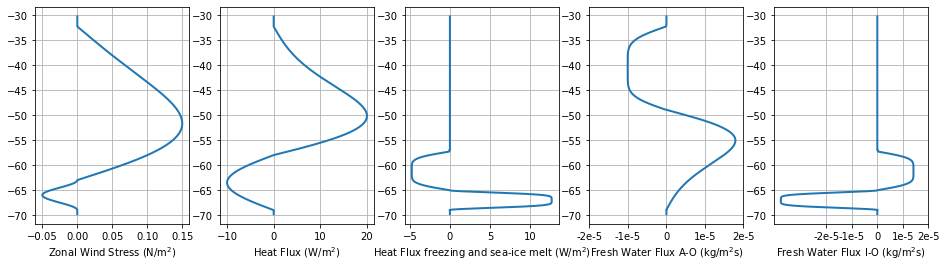

In [20]:
fig = plt.figure(figsize=[16,4])

plt.subplot(1,5,1)
plt.plot(wind['taux'].isel(lonh=0,Time=0), wind['lath'],lw=2, label = 'Analytical')
plt.grid()
plt.xlabel('Zonal Wind Stress (N/m$^2$)')

plt.subplot(1,5,2)
plt.plot(buoyancy['sensible'].isel(lonh=0,Time=0), buoyancy['lath'],lw=2,label = 'Analytical')
plt.xlabel('Heat Flux (W/m$^2$)')
plt.grid()

plt.subplot(1,5,3)
plt.plot(buoyancy['latent'].isel(lonh=0,Time=0), buoyancy['lath'],lw=2,label = 'Analytical')
plt.xlabel('Heat Flux freezing and sea-ice melt (W/m$^2$)')
plt.grid()

plt.subplot(1,5,4)
plt.plot(buoyancy['liq_precip'].isel(lonh=0,Time=0), buoyancy['lath'],lw=2,label = 'Analytical')
plt.xticks([-2e-5, -1e-5, 0, 1e-5, 2e-5], ['-2e-5', '-1e-5', '0', '1e-5','2e-5'])
plt.xlabel('Fresh Water Flux A-O (kg/m$^2$s)')
plt.grid()

plt.subplot(1,5,5)
plt.plot(buoyancy['froz_precip'].isel(lonh=0,Time=0), buoyancy['lath'],lw=2,label = 'Analytical')
plt.xticks([-2e-5, -1e-5, 0, 1e-5, 2e-5], ['-2e-5', '-1e-5', '0', '1e-5','2e-5'])
plt.xlabel('Fresh Water Flux I-O (kg/m$^2$s)')
plt.grid()

$\large \text{Sea surface profiles}$

In [34]:
def salinity_vallis_2006(rho, theta):

    # Simpler nonlinear equation of state (Nycander et al., 2015)
    g = 9.8; c = 1500.; 
    rho_0 = 1027.; theta_0 = 10; S_0 = 35.;
    z = 0.
    
    gamma_b = 1.1179*1.e-4; gamma_c = 1.e-5; 
    alpha = 1.67*1.e-4; beta = 0.78*1.e-3 
    
    b = -g * (rho - rho_0)/rho_0
    
    S = -b/g -g*z/c**2 + alpha*(1 + gamma_b * z)*(theta - theta_0) + 0.5 * gamma_c * (theta - theta_0)**2
    
    S = S / beta + S_0
    
    return S

def density_vallis_2006(S, theta):
    
    # Simpler nonlinear equation of state (Nycander et al., 2015)
    g = 9.8; c = 1500.; 
    rho_0 = 1027.; theta_0 = 10; S_0 = 35.;
    z = 0.
    
    gamma_b = 1.1179*1.e-4; gamma_c = 1.e-5; 
    alpha = 1.67*1.e-4; beta = 0.78*1.e-3
    
    b = g*(-g*z/c**2 + alpha*(1 + gamma_b * z)*(theta - theta_0) + 0.5 * gamma_c * (theta - theta_0)**2 - beta*(S-S_0))
    
    density = rho_0 - b*rho_0/g - 1000.  
    
    return density

In [35]:
# Temperature and salinity initial conditions
Tn = 22; Ts = -1.
Ys = Y.isel(lonh =0, lath = np.abs(Y.lath.values + 43.0).argmin()).values
Ws = 1.e6

TS = xr.Dataset()
TS['SST'] = infs.calc_distribution(coordinate = Y, function='tan_hyperbolic', val_at_maxcoord = Tn, 
                                   val_at_mincoord = Ts, Ys = Ys, Ws = Ws)

Sn = 35.6; Ss = 34.0; Ws = 3.5e5
TS['SSS'] = infs.calc_distribution(coordinate = Y, function='tan_hyperbolic', val_at_maxcoord = Sn, 
                                   val_at_mincoord = Ss, Ys = Ys, Ws = Ws)

TS['SS_rho'] = xr.apply_ufunc(density_vallis_2006, TS['SSS'], TS['SST'], dask='parallelized', 
                             output_dtypes=[TS.SST.dtype])

#TS.to_netcdf('../../MOM6_Channel_Input/Res_008/TS'+'.nc')

print(TS)

<xarray.Dataset>
Dimensions:  (lath: 816, lonh: 960)
Coordinates:
  * lath     (lath) float64 -69.99 -69.97 -69.94 -69.91 ... -30.17 -30.1 -30.02
  * lonh     (lonh) float64 0.04167 0.125 0.2083 0.2917 ... 79.79 79.88 79.96
Data variables:
    SST      (lath, lonh) float64 -0.9434 -0.9434 -0.9434 ... 20.79 20.79 20.79
    SSS      (lath, lonh) float64 34.0 34.0 34.0 34.0 ... 35.6 35.6 35.6 35.6
    SS_rho   (lath, lonh) float64 27.46 27.46 27.46 27.46 ... 25.03 25.03 25.03


$\large \text{Sponge Specification}$

In [41]:
sponge_wid = 1.65 # in degrees
sp_wid = np.max(Y.isel(lonh=0).values) - Y.isel(lonh =0, lath = np.abs(Y.lath.values - np.max(Y.lath.values) 
                                                                       + sponge_wid).argmin()).values 

print(sp_wid)

182619.0522893807


In [43]:
# To make that this is the same as in low res model
Y.lath.values[np.abs(Y.lath.values - np.max(Y.lath.values) + sponge_wid).argmin()]

-31.952162238024968

In [44]:
sponge_wid = 1.65 # in degrees
sp_wid = np.max(Y.isel(lonh=0).values) - Y.isel(lonh =0, lath = np.abs(Y.lath.values - np.max(Y.lath.values) 
                                                                       + sponge_wid).argmin()).values 

sponge_width = [sp_wid, 0*sp_wid/2.] # This is the sponge in wind stress file

idampval = 1./(7.*86400.)

sponge = xr.Dataset()
sponge['idampseven'] = infs.def_sponge_damping_linear_north(Y,sponge_width=sp_wid,idampval_max=idampval)

idampval = 1./(1.*86400.) # Relaxation of 1 days in sponge width at the northern boundary
sponge['idampone'] = infs.def_sponge_damping_linear_north(Y,sponge_width=sp_wid,idampval_max=idampval)

sponge.idampseven.attrs['units'] = "1/s"
sponge.idampseven.attrs['standard_name'] = "Inverse restoring time scale"
sponge.idampseven.attrs['_FillValue'] = -1.e34
sponge.idampseven.attrs['missing_value'] = -1.e34

sponge.idampone.attrs['units'] = "1/s"
sponge.idampone.attrs['standard_name'] = "Inverse restoring time scale"
sponge.idampone.attrs['_FillValue'] = -1.e34
sponge.idampone.attrs['missing_value'] = -1.e34

sponge.lonh.attrs['units'] = "degrees_east"
sponge.lonh.attrs['standard_name'] = "Longitude"
sponge.lonh.attrs['cartesian_axis'] = "X"
sponge.lonh.encoding['_FillValue'] = False

sponge.lath.attrs['units'] = "degrees_north"
sponge.lath.attrs['standard_name'] = "Latitude"
sponge.lath.attrs['cartesian_axis'] = "Y"
sponge.lath.encoding['_FillValue'] = False

print(sponge)

sponge.to_netcdf('/work/Hemant.Khatri/MOM6_idealised/PEM_ACC/N_75/MOM6_Channel_Input/Res_008_new/sponge'+'.nc')

<xarray.Dataset>
Dimensions:     (lath: 805, lonh: 954)
Coordinates:
  * lath        (lath) float64 -69.79 -69.77 -69.74 ... -30.46 -30.38 -30.31
  * lonh        (lonh) float64 0.2917 0.375 0.4583 0.5417 ... 79.54 79.62 79.71
Data variables:
    idampseven  (lath, lonh) float64 -0.0 -0.0 -0.0 ... 1.653e-06 1.653e-06
    idampone    (lath, lonh) float64 -0.0 -0.0 -0.0 ... 1.157e-05 1.157e-05


(-35.0, -30.0)

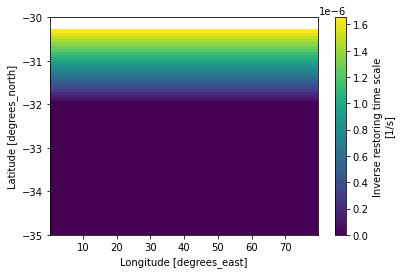

In [46]:
sponge['idampseven'].plot()
plt.ylim((-35,-30))

In [45]:
# Better to use initial conditions of model run to use for sponge profiles because layers move around topography.

"""
sponge_TS = xr.Dataset()

sponge_TS['T'] = (infs.calc_distribution(coordinate=-vgrid.zt, function = 'exponential', 
                                  val_at_maxcoord = TS['SST'], efolding = 800))

rho = (infs.calc_distribution(coordinate=-vgrid.zt, function = 'exponential', 
                              val_at_maxcoord = TS['SS_rho'] - 27.8, efolding = 800))

sponge_TS['rho'] = (infs.calc_distribution(coordinate=-vgrid.zt,function='uniform',uniform_value = 27.8)
          + rho) 

sponge_TS['S'] = xr.apply_ufunc(salinity_vallis_2006, sponge_TS['rho'] + 1000., sponge_TS['T'], dask='parallelized', 
                         output_dtypes=[sponge_TS.T.dtype])

sponge_TS['eta'] = infs.def_sponge_interfaceheight(vgrid,Y)

sponge_TS.lonh.encoding['_FillValue'] = False
sponge_TS.lath.encoding['_FillValue'] = False
sponge_TS.NK.encoding['_FillValue'] = False
sponge_TS.NKp1.encoding['_FillValue'] = False
sponge_TS.T.attrs['_FillValue'] = -1.e34
sponge_TS.S.attrs['_FillValue'] = -1.e34
sponge_TS.eta.attrs['_FillValue'] = -1.e34
sponge_TS.rho.attrs['_FillValue'] = -1.e34

sponge_TS = sponge_TS.transpose('NK','NKp1','lath','lonh')

sponge_TS.to_netcdf('../../MOM6_Channel_Input/Res_008/sponge_TS'+'.nc')

print(sponge_TS)
"""

<xarray.Dataset>
Dimensions:  (NK: 75, NKp1: 76, lath: 816, lonh: 960)
Coordinates:
  * lath     (lath) float64 -69.99 -69.97 -69.94 -69.91 ... -30.17 -30.1 -30.02
  * lonh     (lonh) float64 0.04167 0.125 0.2083 0.2917 ... 79.79 79.88 79.96
  * NK       (NK) float64 0.5 2.393 6.02 11.3 ... 3.748e+03 3.848e+03 3.949e+03
  * NKp1     (NKp1) float64 0.0 1.0 3.787 8.252 ... 3.798e+03 3.898e+03 4e+03
Data variables:
    T        (NK, lath, lonh) float64 -0.9428 -0.9428 -0.9428 ... 0.1493 0.1493
    rho      (NK, lath, lonh) float64 27.46 27.46 27.46 ... 27.78 27.78 27.78
    S        (NK, lath, lonh) float64 34.0 34.0 34.0 34.0 ... 34.49 34.49 34.49
    eta      (NKp1, lath, lonh) float64 -0.0 -0.0 -0.0 ... -4e+03 -4e+03 -4e+03


$\large \text{Topography}$

In [48]:
Y.lonh.values[np.abs(Y.lonh.values - 29.875).argmin()]

29.874999999999993

In [49]:
max_depth = 4000.

Ys = Y.isel(lonh =0, lath = np.abs(Y.lath.values + 66.5).argmin()).values
min_shelf_depth, shelf_lat, shelf_width = (500., Ys, 1.e5)

d_shelf = (infs.make_topography(function='shelf', H=max_depth, Hs=min_shelf_depth, Y1=Y, 
                                Ys=shelf_lat, Ws=shelf_width))

bump_lat = Y.isel(lonh =0, lath = np.abs(Y.lath.values + 52.).argmin()).values

#ind = 358 # index changes as function of resolution (lon = 29.875), 120 for 1/4th, 355 for 1/12th
ind = np.abs(Y.lonh.values - 29.875).argmin()

bump_lon = X.isel(lonh = ind) 

bump_width = np.abs(Y.isel(lonh =0, lath = np.abs(Y.lath.values + 48.).argmin()).values -
                    Y.isel(lonh =0, lath = np.abs(Y.lath.values + 55.).argmin()).values)
bump_length = np.abs(X.isel(lath =0, lonh = np.abs(X.lonh.values - 30.).argmin()).values -
                    X.isel(lath =0, lonh = np.abs(X.lonh.values - 50.).argmin()).values)

d_bump = (infs.make_topography(function='bump', Hs=3000., Y1=Y, X1=X, Wx=bump_length, Wy=bump_width,
                              Xs=bump_lon, Ys=bump_lat, dx=1.0, dy=1.0))

ridge_width = np.abs(X.isel(lath =0, lonh = np.abs(X.lonh.values - 37.).argmin()).values -
                    X.isel(lath =0, lonh = np.abs(X.lonh.values - 42.).argmin()).values)
ridge_length = 1.e7
ridge_lat = Y.isel(lonh =0, lath = np.abs(Y.lath.values + 52.).argmin()).values
ridge_lon = X.isel(lonh = ind)

d_ridge = (infs.make_topography(function='ridge', Hs=2000., Y1=Y, X1=X, Wy=ridge_length, Wx=ridge_width,
                              Xs=ridge_lon, Ys=ridge_lat, theta=0.))

topography = xr.Dataset()
height = np.maximum(-d_shelf, np.minimum(d_bump, 2000.))
topography['depth_bump'] = -1*(-max_depth + height)

height = np.maximum(-d_shelf, d_ridge)
topography['depth_ridge'] = -1*(-max_depth + height)

topography.depth_bump.attrs['units'] = "m"
topography.depth_bump.attrs['standard_name'] = "Ocean Depth Bump case"
topography.depth_bump.attrs['missing_value'] = -1.e34
topography.depth_bump.encoding['_FillValue'] = -1.e34

topography.depth_ridge.attrs['units'] = "m"
topography.depth_ridge.attrs['standard_name'] = "Ocean Depth Ridge case"
topography.depth_ridge.attrs['missing_value'] = -1.e34
topography.depth_ridge.encoding['_FillValue'] = -1.e34

topography.transpose('lath','lonh')
topography.to_netcdf('/work/Hemant.Khatri/MOM6_idealised/PEM_ACC/N_75/MOM6_Channel_Input/Res_008_new/topography'+'.nc')

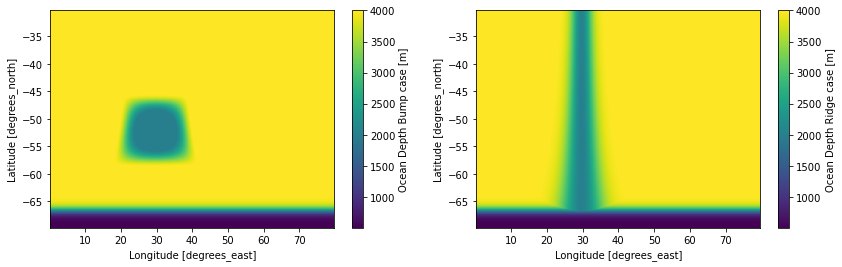

In [50]:
fig = plt.figure(figsize=[14,4])

plt.subplot(1,2,1)
topography.depth_bump.plot()

plt.subplot(1,2,2)
topography.depth_ridge.plot()

$\large \text{Tracer and velocity fields for initialization}$

The model can intiliazed directly from low res output

We use the restart file generated from coarse resolution simulation to create input file for higher resolution simulation. Tracer and velocity fields are read from the restart file and interpolated on higher resolution grid such that MOM6 can read the data. For higher resolution simulations, we use TS_CONFIG method to initialize the model as supplying velocities is not possible in INIT_LAYERS_FROM_Z_FILE method.

In [2]:
ppdir = "/work/Hemant.Khatri/MOM6_idealised/PEM_ACC/N_75/Z_star/TS_Wright/Res_025/"
#res_data = xr.open_mfdataset(ppdir+"prog_z*.nc",decode_times=False)
res_data = xr.open_dataset(ppdir+"MOM.res.nc",decode_times=False)

print(res_data)

<xarray.Dataset>
Dimensions:      (Interface: 76, Layer: 75, Time: 1, lath: 272, latq: 272, lonh: 320, lonq: 320)
Coordinates:
  * lath         (lath) float64 -69.94 -69.85 -69.77 ... -30.46 -30.24 -30.02
  * lonh         (lonh) float64 0.125 0.375 0.625 0.875 ... 79.38 79.62 79.88
  * latq         (latq) float64 -69.89 -69.81 -69.72 ... -30.35 -30.13 -29.92
  * lonq         (lonq) float64 0.25 0.5 0.75 1.0 1.25 ... 79.25 79.5 79.75 80.0
  * Layer        (Layer) float64 0.5 2.393 6.02 ... 3.848e+03 3.949e+03
  * Interface    (Interface) float64 0.0 1.0 3.787 ... 3.798e+03 3.898e+03 4e+03
  * Time         (Time) float64 1.8e+04
Data variables:
    Temp         (Time, Layer, lath, lonh) float64 ...
    Salt         (Time, Layer, lath, lonh) float64 ...
    h            (Time, Layer, lath, lonh) float64 ...
    u            (Time, Layer, lath, lonq) float64 ...
    v            (Time, Layer, latq, lonh) float64 ...
    ave_ssh      (Time, lath, lonh) float64 ...
    m_to_Z       (Time) fl

In [5]:
TS_data = res_data[['Temp','Salt','h']]

TS_data['u'] = xr.DataArray(res_data['u'].values,dims=['Time','Layer', 'lat', 'lon'])

TS_data['v'] = xr.DataArray(res_data['v'].values,dims=['Time','Layer', 'lat', 'lon'])



TS_data = TS_data.rename({'lonh': 'lon','lath': 'lat'})

ds_TS = xr.Dataset({'lat':(['lat'], lat),
                       'lon':(['lon'], lon),})

regridder = xe.Regridder(TS_data, ds_TS, 'bilinear', periodic=True, reuse_weights=False)
regridder.clean_weight_file()
print(regridder)

Create weight file: bilinear_272x320_816x960_peri.nc
Remove file bilinear_272x320_816x960_peri.nc
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_272x320_816x960_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (272, 320) 
Output grid shape:          (816, 960) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      True


In [6]:
ds_TS = regridder(TS_data)
print(ds_TS)

using dimensions ('lat', 'lon') from data variable Temp as the horizontal dimensions for this dataset.
<xarray.Dataset>
Dimensions:  (Layer: 75, Time: 1, lat: 816, lon: 960)
Coordinates:
  * Layer    (Layer) float64 0.5 2.393 6.02 ... 3.748e+03 3.848e+03 3.949e+03
  * Time     (Time) float64 1.8e+04
  * lon      (lon) float64 0.04167 0.125 0.2083 0.2917 ... 79.79 79.88 79.96
  * lat      (lat) float64 -69.99 -69.97 -69.94 -69.91 ... -30.17 -30.1 -30.02
Data variables:
    Temp     (Time, Layer, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.1494 0.0
    Salt     (Time, Layer, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 34.49 0.0
    h        (Time, Layer, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 101.9 0.0
    u        (Time, Layer, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.003837 0.0
    v        (Time, Layer, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  bilinear


In [9]:
#ds_TS['u'].isel(Time=0,lat=815,lon=7).plot()
ds_TS['lat']

<xarray.DataArray 'lat' (lat: 816)>
array([-69.994767, -69.966239, -69.937672, ..., -30.167644, -30.095571,
       -30.023446])
Coordinates:
  * lat      (lat) float64 -69.99 -69.97 -69.94 -69.91 ... -30.17 -30.1 -30.02

In [10]:
# Get rid of zero values on boundaries (can be checked by plotting the data)

ds1 = ds_TS.isel(Time=0)
ds1 = ds1.drop('Time')

for i in list(ds_TS.keys()):
    
    tmp = ds1[i].values
    
    # On northern boundary have uniform values along x
    for j in range(0,tmp.shape[2]):
        tmp[:,tmp.shape[1]-1,j] = tmp[:,tmp.shape[1]-1,7]
    
    # make first and last lon periodic
    tmp[:,:,0] = tmp[:,:,-2]
    tmp[:,:,-1] = tmp[:,:,1]
    
    # southern boundary extend values to the end
    for j in range(0,2):
        tmp[:,j,:] = tmp[:,2,:]
    
    ds1 = ds1.drop(i)
    #ds1[i] = (['Time', 'Layer', 'lat', 'lon'],  tmp)
    ds1[i] = xr.DataArray(tmp,dims=['Layer', 'lat', 'lon'])
    
#Note: interpolated h causes model to crash. Used thickness ='coord' option to run. Need to see this.

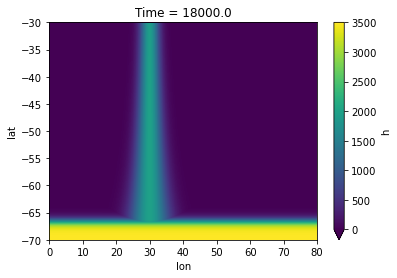

In [31]:
(4000. - ds1['h'].sum('Layer')).plot(vmin=0., vmax = 3500.)

In [16]:
ds1.lat.encoding['_FillValue'] = False
ds1.lon.encoding['_FillValue'] = False
ds1.Layer.encoding['_FillValue'] = False

ds1.Temp.attrs['_FillValue'] = -1.e34
ds1.Salt.attrs['_FillValue'] = -1.e34
ds1.h.attrs['_FillValue'] = -1.e34
ds1.u.attrs['_FillValue'] = -1.e34
ds1.v.attrs['_FillValue'] = -1.e34

print(ds1)

ds1.to_netcdf('../../MOM6_Channel_Input/Res_008/TS_init'+'.nc')

<xarray.Dataset>
Dimensions:  (Layer: 75, lat: 816, lon: 960)
Coordinates:
  * Layer    (Layer) float64 0.5 2.393 6.02 ... 3.748e+03 3.848e+03 3.949e+03
  * lat      (lat) float64 -69.99 -69.97 -69.94 -69.91 ... -30.17 -30.1 -30.02
  * lon      (lon) float64 0.04167 0.125 0.2083 0.2917 ... 79.79 79.88 79.96
    Time     float64 1.8e+04
Data variables:
    Temp     (Layer, lat, lon) float64 -0.4887 -0.4902 -0.4902 ... 0.1494 0.1494
    Salt     (Layer, lat, lon) float64 34.46 34.46 34.46 ... 34.49 34.49 34.49
    h        (Layer, lat, lon) float64 0.9979 0.9979 0.9979 ... 101.9 101.9
    u        (Layer, lat, lon) float64 -0.0008409 -0.001146 ... -0.01776
    v        (Layer, lat, lon) float64 0.001048 0.001713 0.000965 ... 0.0 0.0
Attributes:
    regrid_method:  bilinear


In [8]:
"""
TS_Z_init = xr.Dataset()

TS_Z_init['T'] = res_data['temp'].isel(Time=49)
TS_Z_init['S'] = res_data['salt'].isel(Time=49)

TS_Z_init = TS_Z_init.rename({'xh': 'LON','yh': 'LAT','z_l': 'DEPTH'})
TS_Z_init = TS_Z_init.drop('Time')
TS_Z_init = TS_Z_init.expand_dims({"TIME":np.array([0.])})

#TS_Z_init.T.attrs['_FillValue'] = -1.e34
#TS_Z_init.T.attrs['missing_value'] = -1.e34
#TS_Z_init.S.attrs['_FillValue'] = -1.e34
#TS_Z_init.S.attrs['missing_value'] = -1.e34

TS_Z_init.LON.encoding['_FillValue'] = False
TS_Z_init.DEPTH.encoding['_FillValue'] = False
TS_Z_init.LAT.encoding['_FillValue'] = False
TS_Z_init.TIME.encoding['_FillValue'] = False
"""

In [170]:
#print(TS_Z_init)

#TS_Z_init.to_netcdf('../../MOM6_Channel_Input/Res_008/TS_init_Z'+'.nc')

$\large \text{Density levels in MOM6}$

In [11]:
def rho_function1(nk,rho_1,rho_2,rho_3,drho,rho_4,drho_min,plot=True):
    rho_target = np.zeros(nk+1)
    rho_target[:]=np.nan
    rho_target[0]=rho_1
    rho_target[1]=rho_2

    nki = nk+1-4
    dx = 0
    for k in range(nki+1):
        ddx = np.max([drho_min, (nki-k)/(nki*nki)])
        dx = dx + ddx
        rho_target[3-1+k] = rho_3 + (2*drho)*dx
    
    rho_target[nki+4-1]=rho_4
    
    if plot:
        plt.plot(np.diff(rho_target),(rho_target[1:]+rho_target[:-1])/2,'.')
        plt.gca().set_xlim([0,1])
        plt.gca().set_title('delta rho as a function of rho')
    
    return rho_target

[1020.         1021.         1022.375      1022.73828125 1023.08984375
 1023.4296875  1023.7578125  1024.07421875 1024.37890625 1024.671875
 1024.953125   1025.22265625 1025.48046875 1025.7265625  1025.9609375
 1026.18359375 1026.39453125 1026.59375    1026.78125    1026.95703125
 1027.12109375 1027.2734375  1027.4140625  1027.54296875 1027.66015625
 1027.765625   1027.859375   1027.953125   1028.046875   1028.140625
 1028.234375   1028.328125   1028.421875   1028.515625   1028.609375
 1029.        ]


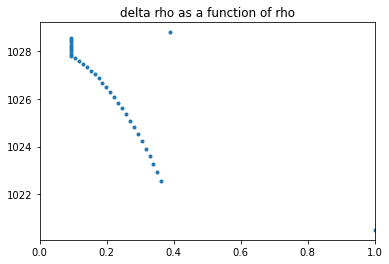

In [21]:
nk = 35
rho_1 = 1020.0
rho_2 = 1021.0
rho_3 = 1022.0
drho = 6.0
rho_4 = 1029.0
drho_min = 0.0078125

rho_target = rho_function1(nk,rho_1,rho_2,rho_3,drho,rho_4,drho_min)
print(rho_target)